In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import tensorflow as tf
from scipy import stats
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2

from matplotlib import cm

from tqdm import tqdm
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib import cm

# Data
from seird.model import data_generator, version_data_model
from seird.sanity_checks import sampling_sc

# Model
from bayesflow.networks import SequenceNet, HeteroskedasticModel
from bayesflow.bayesflow_model import BayesFlow
from bayesflow.trainer import train_step
from bayesflow.losses import heteroskedastic_loss, maximum_likelihood_loss

# Misc
from utils.misc import (true_vs_estimated, plot_parameters_correlation, plot_tseries, plot_predictions)


%load_ext autoreload
%autoreload 2

In [3]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5

# Optional if using the predefined summary nets
summary_meta = {
    'lstm_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}


# Forward model hyperparameters
parameter_names = [r'$\beta$', r'$\sigma$', r'$\gamma$', r'$\mu_I$']
theta_dim = len(parameter_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "bayesflow_parameter_estimation_v5"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000

starter_learning_rate = 0.001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [4]:
%%time
data_test = data_generator(n_test, version='v5', low_epsilon=0.05, up_epsilon=0.25, learning_noise=False)

# Preprocessing untrained data
X_test = np.array(data_test['X'])
noisy_X_test = np.array(data_test['noisy_X'])
params_test = np.array(data_test['params'])

CPU times: user 198 ms, sys: 7.55 ms, total: 206 ms
Wall time: 201 ms


In [5]:
print(type(X_test))
print(X_test.shape)
print(type(noisy_X_test))
print(noisy_X_test.shape)
print(type(params_test))
print(params_test.shape)

<class 'numpy.ndarray'>
(500, 100, 5)
<class 'numpy.ndarray'>
(500, 100, 5)
<class 'numpy.ndarray'>
(500, 4)


In [6]:
# Sanity checks for numerical stability
assert(np.sum(X_test == np.inf) == 0)
assert(np.sum(X_test == -np.inf) == 0)
assert(np.sum(X_test == np.nan) == 0)

assert(np.sum(noisy_X_test == np.inf) == 0)
assert(np.sum(noisy_X_test == -np.inf) == 0)
assert(np.sum(noisy_X_test == np.nan) == 0)

In [7]:
# Instantiate model
summary_net = SequenceNet()
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

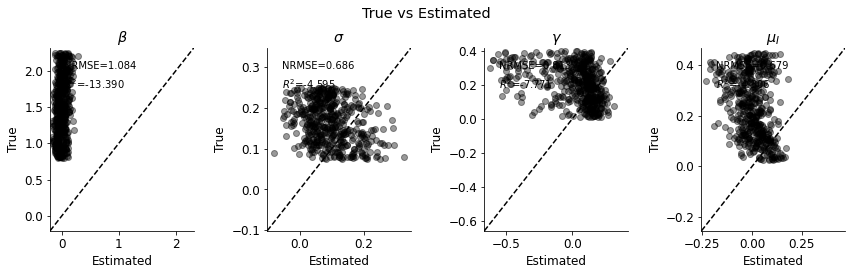

In [8]:
true_vs_estimated(model, noisy_X_test, params_test, n_samples_posterior, parameter_names, figsize=(12, 4))

In [9]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/bayesflow_parameter_estimation_v5/ckpt-219


In [ ]:
# %%time
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_step(
            model=model, 
            optimizer=optimizer,
            loss_fn=maximum_likelihood_loss, 
            iterations=iterations_per_epoch,
            batch_size=batch_size,
            p_bar=p_bar,
            global_step=global_step,
            version='v5',
            learning_noise=False
        ) 

        # Manage checkpoint
        manager.save()

In [10]:
# Sample from trained model
params_samples = model.sample(noisy_X_test, n_samples_posterior, to_numpy=True)

# For each tseries compute mean of sampled posteriors
# For each tseries, n_samples_posterior set of parameters were samples
params_samples_mean = params_samples.mean(axis=0)

In [11]:
params_samples_mean.shape

(500, 4)

In [12]:
# Sampling sanity checks
sc_params_samples_mean, sc_params_test, sc_params_samples, noisy_sc_X_test, sc_X_test = sampling_sc(params_samples_mean, params_test, params_samples, noisy_X_test, X_test, version='v5')

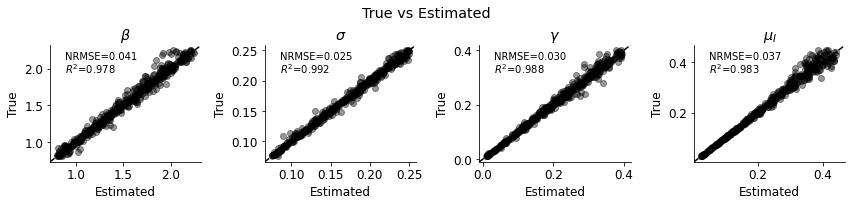

In [13]:
true_vs_estimated(model, sc_X_test, sc_params_test, n_samples_posterior, parameter_names, figsize=(12, 3), params_samples_mean=sc_params_samples_mean)

In [14]:
# Select random tseries
sel_idx = np.random.choice(sc_params_samples_mean.shape[0], 1, replace=False)

In [15]:
sel_params_samples = sc_params_samples[:, sel_idx, :].squeeze()
sel_params_test = sc_params_test[sel_idx, :].squeeze()
sel_X_test = sc_X_test[sel_idx, :].squeeze().reshape(-1, 5)
sel_noisy_X_test = noisy_sc_X_test[sel_idx, :].squeeze().reshape(-1, 5)

<Figure size 432x288 with 0 Axes>

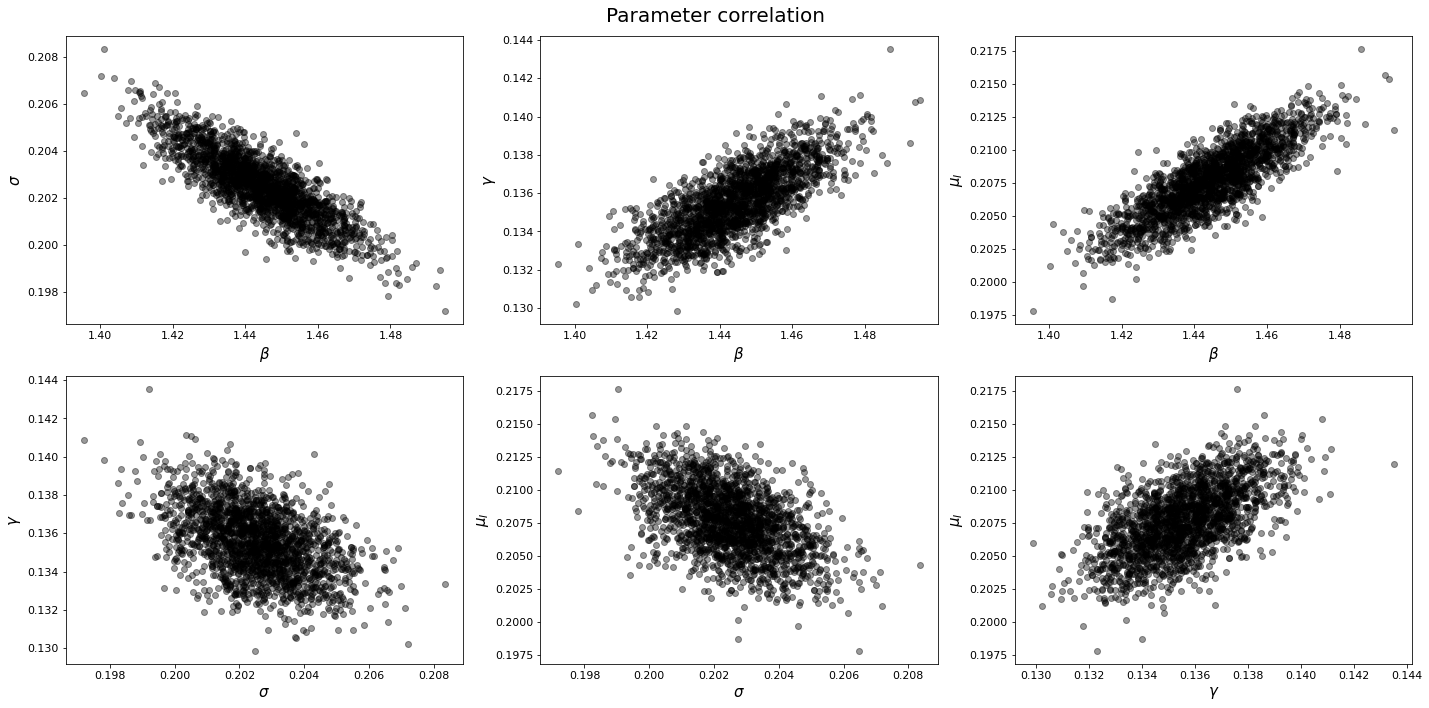

<Figure size 1440x720 with 0 Axes>

In [16]:
plot_parameters_correlation(sel_params_samples, parameter_names)

In [17]:
# Resimulation
t_obs = 100
dt = 1
t = np.linspace(0, t_obs, int(t_obs/dt))
N = 1000
init_vals = 1 - 1/N, 1/N, 0, 0, 0
forward_model = partial(version_data_model, initial_values=init_vals, version='v5', learning_noise=False)

In [18]:
tseries = np.empty((sel_params_samples.shape[0], t_obs, 5))
for i in range(sel_params_samples.shape[0]):
    tseries[i, :, :] = forward_model(sel_params_samples[i, :], t=t)

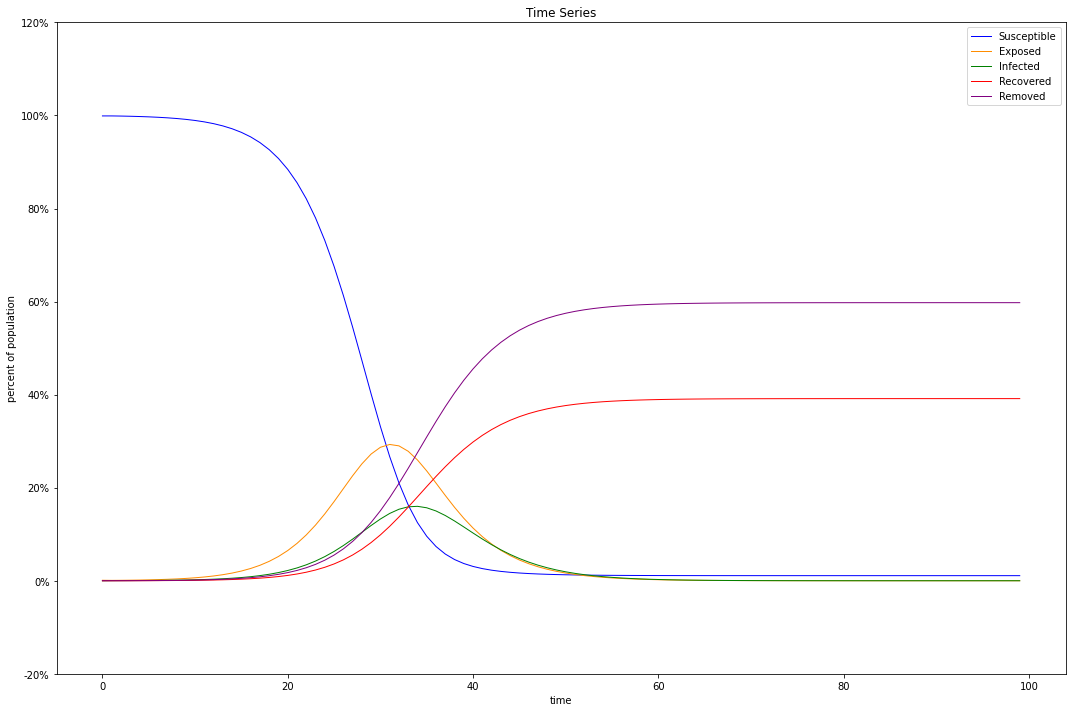

<Figure size 1080x720 with 0 Axes>

In [19]:
labels = ['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Removed']
plot_tseries(tseries, labels)

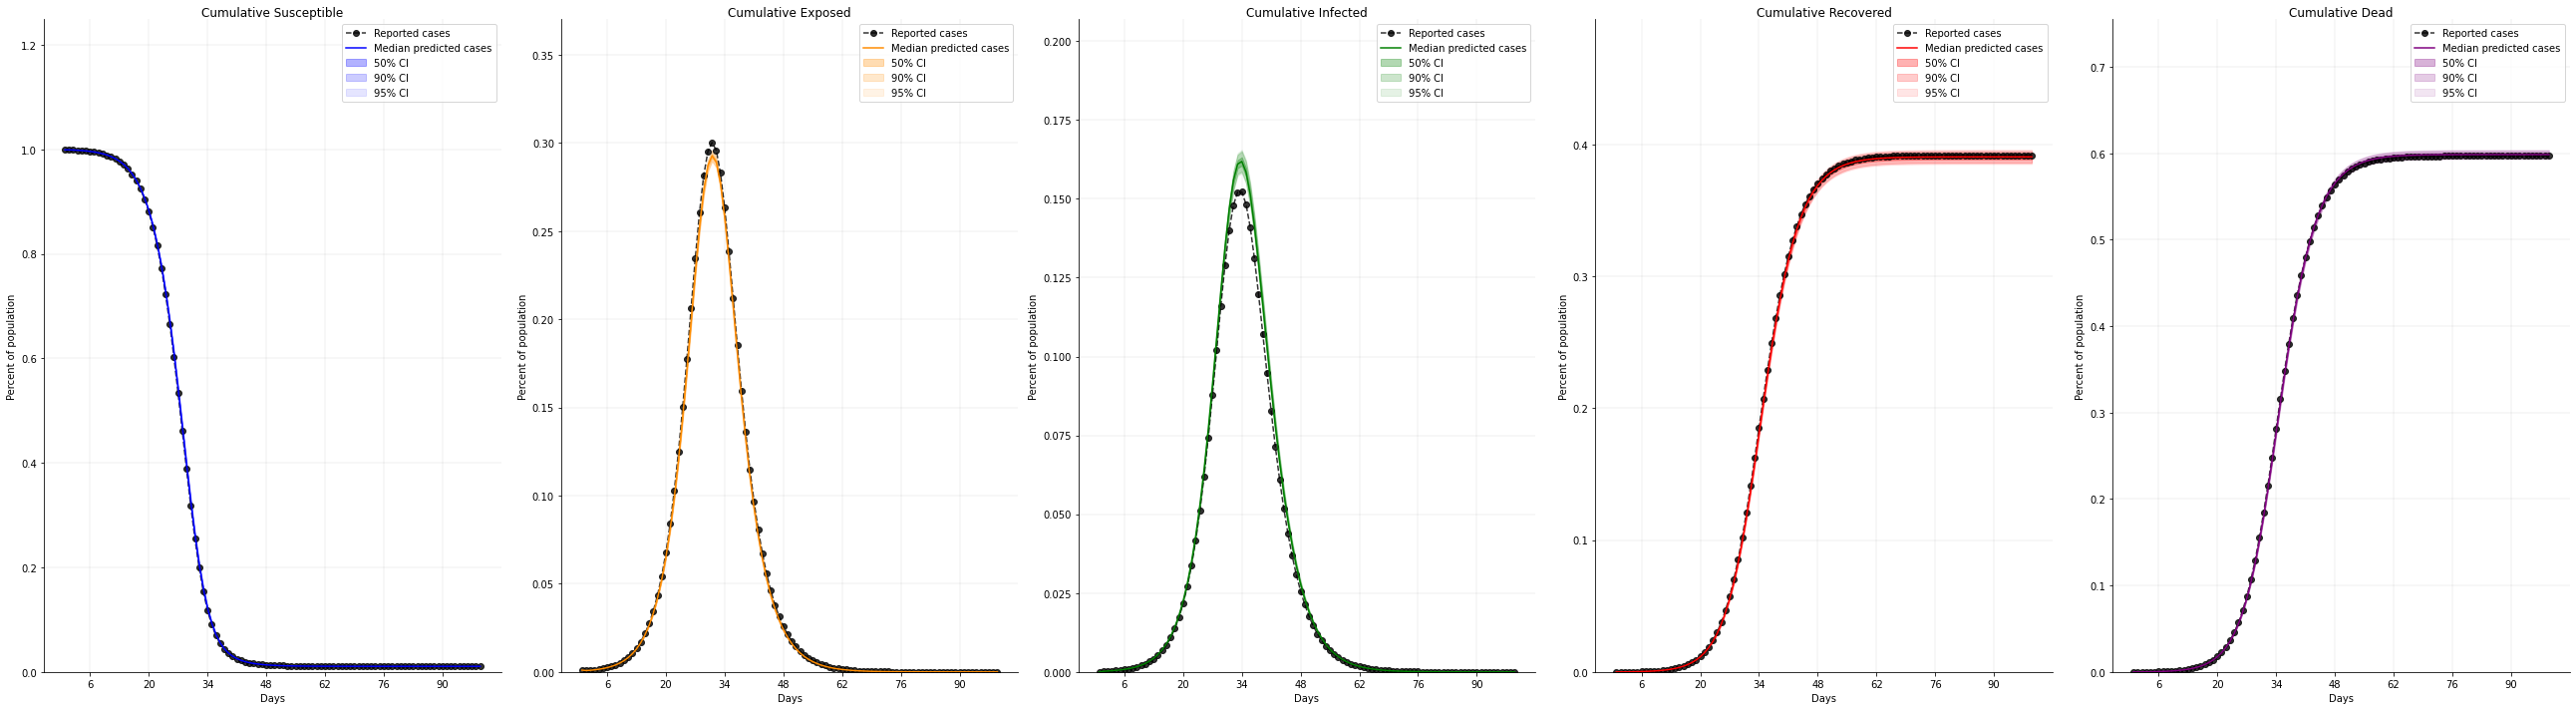

In [20]:
plot_predictions(t_obs, sel_X_test, tseries)

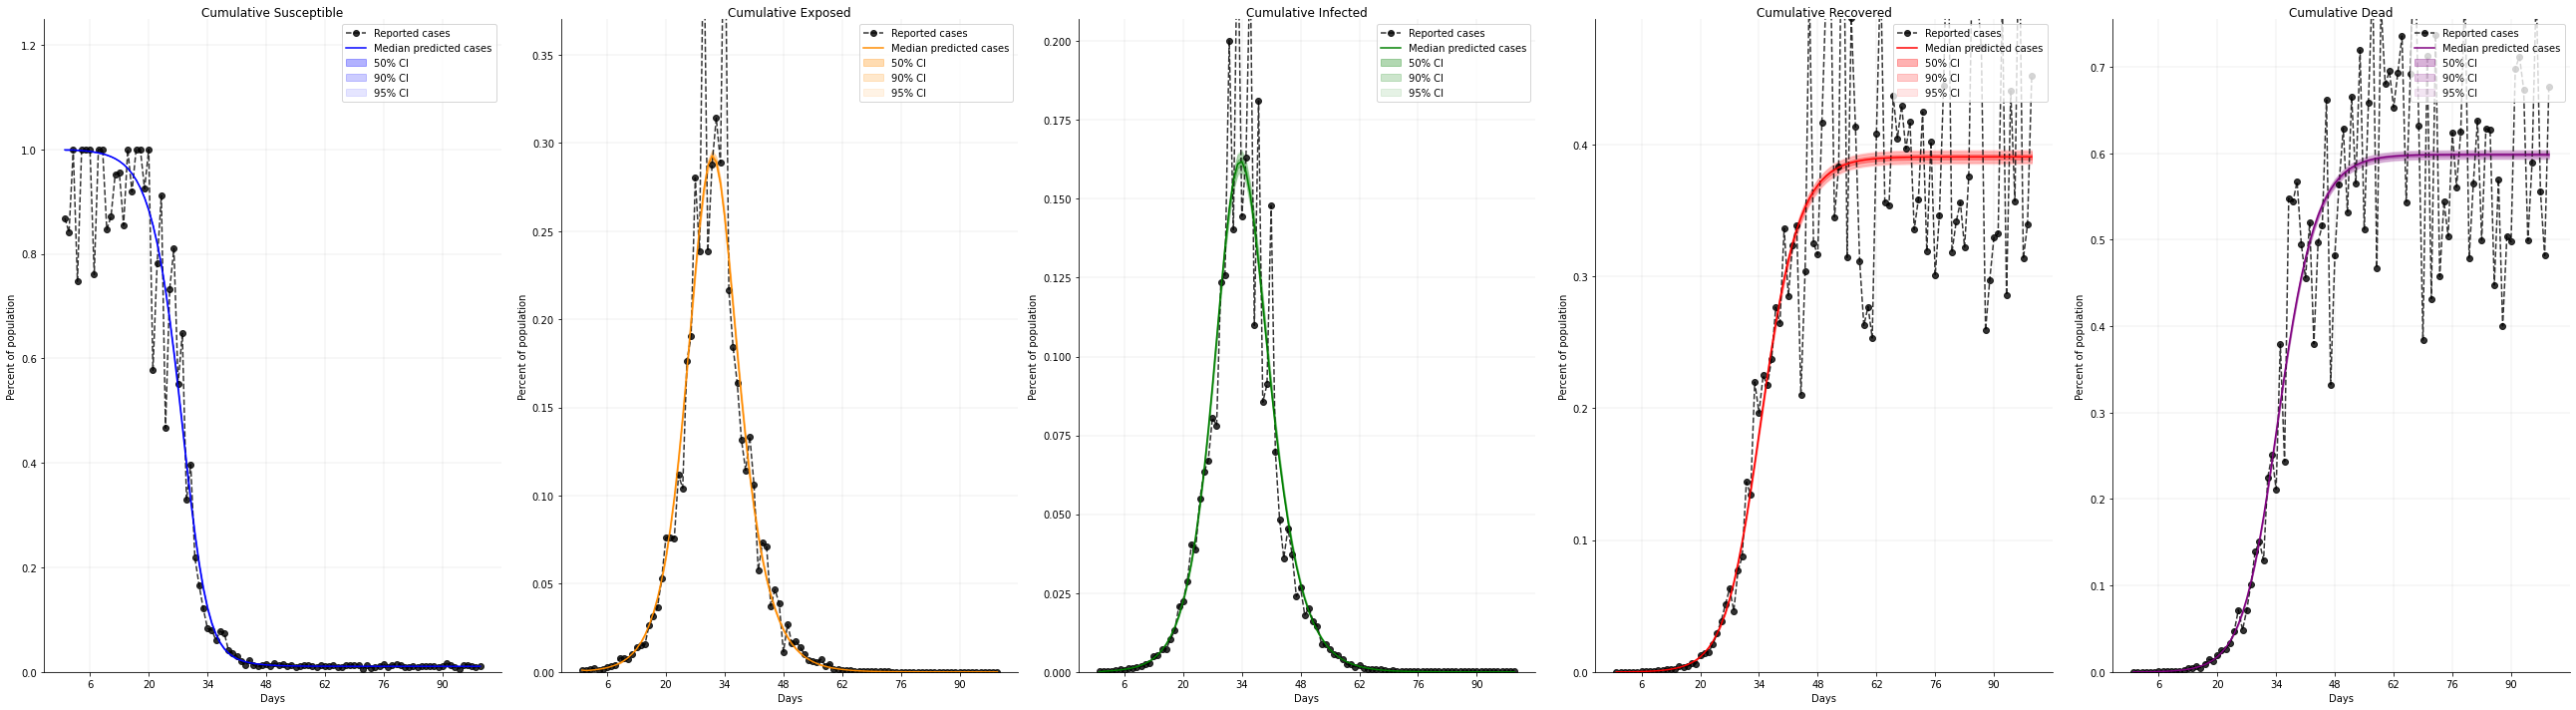

In [21]:
plot_predictions(t_obs, sel_noisy_X_test, tseries)